### Importujeme potrebné balíky

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima_model import ARIMA
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Import dát

In [2]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = "2022-03-31", 
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [5]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

### Vytvorenie výnosov

In [6]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

### Rozdelenie dát 80/20

In [7]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Auto_arima model

In [8]:
from pmdarima.arima import auto_arima

In [9]:
model_auto = auto_arima(df.ret_ftse[1:])

In [10]:
model_auto

ARIMA(order=(4, 0, 5), scoring_args={}, suppress_warnings=True)

In [11]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5890
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -9104.900
Date:                Mon, 02 May 2022   AIC                          18231.801
Time:                        18:17:14   BIC                          18305.292
Sample:                             0   HQIC                         18257.346
                               - 5890                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0259      0.021      1.216      0.224      -0.016       0.068
ar.L1         -0.0155      0.080     -0.195      0.846      -0.172       0.141
ar.L2         -0.5732      0.079     -7.233      0.000      -0.728      -0.418
ar.L3         -0.2194      0.071     -3.085      0.002      -0.359      -0.080
ar.L4          0.2784      0.077      3.599      0.000       0.127       0.430
ma.L1         -0.0074      0.079     -0.094      0.925      -0.163       0.148
ma.L2          0.5243      0.080      6.576      0.000       0.368       0.681
ma.L3          0.1368      0.069      1.969      0.049       0.001       0.273
ma.L4         -0.2826      0.076     -3.709      0.000      -0.432      -0.133
ma.L5         -0.0896      0.009    -10.054      0.000      -0.107      -0.072
sigma2         1.2882      0.013     98.777      0.000       1.263       1.314
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              7353.69
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5890
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -9104.900
Date:                Mon, 02 May 2022   AIC                          18231.801
Time:                        18:17:14   BIC                          18305.292
Sample:                             0   HQIC                         18257.346
                               - 5890                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0259      0.021      1.216      0.224      -0.016       0.068
ar.L1         -0.0155      0.080     -0.195      0.846      -0.172       0.141
ar.L2         -0.5732      0.079     -7.233      0.0

### Auto ARIMA s plnými kritériami a definíciami

In [13]:
model_auto_bez = auto_arima(
    
df_comp.ret_ftse[1:], 
exogenous = df_comp[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], 
 max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
maxiter = 50, alpha = 0.05, n_jobs = -1, 
trend = 'ct', information_criterion = 'oob',
out_of_sample = int(len(df_comp)*0.2)

)

# !!! Important Note: In pdmarima v1.5.2, out_of_sample_size is replaced with out_of_sample, so make sure to use the latter!


# exogenous -> vonkajšie faktory (napr. iné časové rady)
# m -> dĺžka sezónneho cyklu
# max_order -> maximálne množstvo premenných, ktoré sa majú použiť v regresii (p + q)
# max_p -> maximum AR komponentov
# max_q -> maximum MA komponentov
# max_d -> maximum integrácií
# maxiter -> maximum iterácií ktoré dávame modelu na konvergenciu koeficientov (s rastúcim poradím sa stáva ťažším)
# alpha -> úroveň významnosti, predvolená hodnota je 5 %, ktorú by sme mali používať väčšinu času
# n_jobs -> koľko modelov sa zmestí naraz (-1 označuje „toľko, koľko je možné“)
# trend -> "ct" najčastejšie
# information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 
#        (Akaike Information Criterion, Corrected Akaike Information Criterion,
#        Bayesian Information Criterion, Hannan-Quinn Information Criterion, alebo
# "out of bag" - pre overenie skóre - v tomto poradí)
# out_of_smaple -> overí výber modelu (odovzdať celý súbor údajov a nastaviť 20 % ako out_of_sample_size)

In [14]:
model_auto_bez.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7363
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -7347.538
Date:                Mon, 02 May 2022   AIC                          14713.075
Time:                        18:18:46   BIC                          14775.213
Sample:                    01-10-1994   HQIC                         14734.433
                         - 03-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0038      0.015     -0.256      0.798      -0.033       0.026
drift      -1.483e-06   3.84e-06     -0.386      0.700   -9.01e-06    6.05e-06
ret_spx        0.0982      0.005     19.406      0.000       0.088       0.108
ret_dax        0.5670      0.004    127.040      0.000       0.558       0.576
ret_nikkei     0.0713      0.004     18.463      0.000       0.064       0.079
ar.L1         -0.0945      0.007    -14.490      0.000      -0.107      -0.082
ar.L2         -0.0231      0.009     -2.650      0.008      -0.040      -0.006
ar.L3         -0.0591      0.008     -7.050      0.000      -0.075      -0.043
sigma2         0.4309      0.004    109.410      0.000       0.423       0.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             16170.87
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
print(model_auto_bez.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7363
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -7347.538
Date:                Mon, 02 May 2022   AIC                          14713.075
Time:                        18:18:46   BIC                          14775.213
Sample:                    01-10-1994   HQIC                         14734.433
                         - 03-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0038      0.015     -0.256      0.798      -0.033       0.026
drift      -1.483e-06   3.84e-06     -0.386      0.700   -9.01e-06    6.05e-06
ret_spx        0.0982      0.005     19.406      0.0

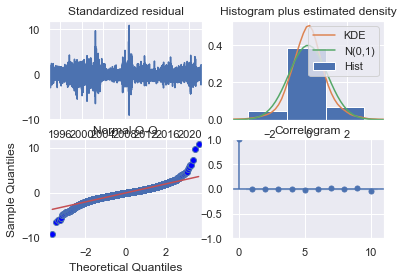

In [16]:
model_auto_bez.plot_diagnostics()
plt.show()

In [17]:
model_auto = auto_arima(df_comp.ret_ftse[1:], exogenous = df_comp[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m = 5,
                       max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(df_comp)*0.2))


# !!! Important Note: In pdmarima v1.5.2, out_of_sample_size is replaced with out_of_sample, so make sure to use the latter!


# exogenous -> vonkajšie faktory (napr. iné časové rady)
# m -> dĺžka sezónneho cyklu
# max_order -> maximálne množstvo premenných, ktoré sa majú použiť v regresii (p + q)
# max_p -> maximum AR komponentov
# max_q -> maximum MA komponentov
# max_d -> maximum integrácií
# maxiter -> maximum iterácií ktoré dávame modelu na konvergenciu koeficientov (s rastúcim poradím sa stáva ťažším)
# alpha -> úroveň významnosti, predvolená hodnota je 5 %, ktorú by sme mali používať väčšinu času
# n_jobs -> koľko modelov sa zmestí naraz (-1 označuje „toľko, koľko je možné“)
# trend -> "ct" najčastejšie
# information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 
#        (Akaike Information Criterion, Corrected Akaike Information Criterion,
#        Bayesian Information Criterion, Hannan-Quinn Information Criterion, alebo
# "out of bag" - pre overenie skóre - v tomto poradí)
# out_of_smaple -> overí výber modelu (odovzdať celý súbor údajov a nastaviť 20 % ako out_of_sample_size)

In [18]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                         y   No. Observations:                 7363
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2, 3], 5)   Log Likelihood               -7345.978
Date:                                   Mon, 02 May 2022   AIC                          14713.957
Time:                                           18:25:31   BIC                          14789.903
Sample:                                       01-10-1994   HQIC                         14740.060
                                            - 03-30-2022                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0037      0.010     -0.381      0.703      -0.022       0.015
drift       -1.43e-06   2.45e-06     -0.585      0.559   -6.22e-06    3.36e-06
ret_spx        0.0982      0.005     19.110      0.000       0.088       0.108
ret_dax        0.5670      0.005    125.883      0.000       0.558       0.576
ret_nikkei     0.0713      0.004     18.378      0.000       0.064       0.079
ar.L1          0.2082      0.082      2.527      0.011       0.047       0.370
ma.L1         -0.3027      0.082     -3.694      0.000      -0.463      -0.142
ma.S.L5       -0.0246      0.008     -3.083      0.002      -0.040      -0.009
ma.S.L10      -0.0449      0.009     -5.255      0.000      -0.062      -0.028
ma.S.L15      -0.0232      0.008     -2.814      0.005      -0.039      -0.007
sigma2         0.4321      0.004    109.619      0.000       0.424       0.440
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15903.98
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""